# Graph Analysis dengan PySpark GraphFrames

---

**Nama:** Muhammad Rizky Hajar  
**NIM:** 24.55.2714  
**Prodi:** PJJ Informatika  
**Konsentrasi:** Big Data dan Predictive Analytics (BDPA)  
**Mata Kuliah:** IT Platform and Infrastructure

---

## Tugas 4: Graph Analysis - Flight Network

**Konteks Tugas:**
- Menggunakan PySpark GraphFrames untuk analisis graph
- Dataset: Flights dan Airports data
- Analisis network penerbangan dan delay patterns
- Visualisasi dengan Bokeh, NetworkX, dan Neo4j

---

### Notebook Contents:
1. Introduction to GraphFrames
2. Setup & Import Libraries
3. Data Capture
4. Graph Construction
5. Graph Analysis & Queries
6. Graph Algorithms
7. Visualization
8. Conclusion

## 1. Introduction to GraphFrames

### Apa itu GraphFrames?

**GraphFrames** adalah package Python untuk graph processing di Apache Spark. GraphFrames menyediakan API tingkat tinggi untuk graph analysis dan memanfaatkan kekuatan Spark DataFrames.

### Komponen Graph:
- **Vertices (Nodes)**: Entitas dalam graph (dalam kasus ini: Airports)
- **Edges**: Koneksi antar vertices (dalam kasus ini: Flight routes)

### Use Case:
Analisis network penerbangan untuk memahami:
- Bandara tersibuk
- Pola delay penerbangan
- Hub airports dan connectivity
- Optimal routes dan shortest paths

## 2. Setup & Import Libraries

In [1]:
# Import libraries
from pyspark.sql import SparkSession
from pyspark.sql.types import *
# Import specific functions to avoid conflicts with Python built-ins
from pyspark.sql.functions import (
    col, avg, count, sqrt, sum as spark_sum, lit, desc, row_number,
    when, length, concat, desc, asc, size, isnan
)
import pandas as pd
import numpy as np

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from bokeh.io import output_file, show
from bokeh.models import (
    GMapPlot, GMapOptions, ColumnDataSource, Circle, Line,
    Range1d, PanTool, WheelZoomTool, BoxSelectTool
)
import folium

# Neo4j connection (optional)
try:
    from py2neo import Graph, Node, Relationship
    NEO4J_AVAILABLE = True
except:
    NEO4J_AVAILABLE = False
    print("Neo4j library not available, skipping Neo4j visualizations")

# Warnings
import warnings
warnings.filterwarnings('ignore')

# Set matplotlib style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("Libraries imported successfully!")

Libraries imported successfully!


In [2]:
# Initialize SparkSession with GraphFrames support
# GraphFrames 0.10.0 supports Spark 4.x!
spark = SparkSession.builder \
    .appName("FlightNetworkGraphAnalysis") \
    .config("spark.driver.memory", "4g") \
    .config("spark.sql.shuffle.partitions", "8") \
    .config("spark.jars.packages", "io.graphframes:graphframes-spark4_2.13:0.10.0") \
    .getOrCreate()

# Set log level
spark.sparkContext.setLogLevel("WARN")

print(f"Spark Version: {spark.version}")
print(f"Spark Session: {spark}")

# Import GraphFrames
from graphframes import GraphFrame
print("✅ GraphFrames 0.10.0 imported successfully!")

:: loading settings :: url = jar:file:/Users/riskihajar/projects/kuliah/dl-tugas-2/venv/lib/python3.12/site-packages/pyspark/jars/ivy-2.5.3.jar!/org/apache/ivy/core/settings/ivysettings.xml
Ivy Default Cache set to: /Users/riskihajar/.ivy2.5.2/cache
The jars for the packages stored in: /Users/riskihajar/.ivy2.5.2/jars
io.graphframes#graphframes-spark4_2.13 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-1c66a14f-15c5-4720-a1e1-6843dceeab4c;1.0
	confs: [default]
	found io.graphframes#graphframes-spark4_2.13;0.10.0 in central
	found io.graphframes#graphframes-graphx-spark4_2.13;0.10.0 in central
:: resolution report :: resolve 54ms :: artifacts dl 2ms
	:: modules in use:
	io.graphframes#graphframes-graphx-spark4_2.13;0.10.0 from central in [default]
	io.graphframes#graphframes-spark4_2.13;0.10.0 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   a

Spark Version: 4.1.1
Spark Session: <pyspark.sql.session.SparkSession object at 0x130d57da0>
✅ GraphFrames 0.10.0 imported successfully!


## 3. Data Capture

### Dataset Description:

1. **airports.dat** - OpenFlights airport database
   - Contains: Airport ID, Name, City, Country, IATA/ICAO codes, Latitude, Longitude, etc.
   
2. **flights.csv** - Flight performance data from Bureau of Transportation Statistics
   - Contains: Flight schedule, delays, origin/destination, dates, etc.

In [3]:
# Define file paths
tripdelaysFilePath = "../data/flights/flights.csv"
airportsnaFilePath = "../data/flights/airports.dat"

print("Data file paths defined")

Data file paths defined


### 3.1 Load Airports Data

In [4]:
# Define schema for airports data
# Format: AirportID, Name, City, Country, IATA, ICAO, Latitude, Longitude, 
#         Altitude, Timezone, DST, Tz_database_time_zone, Type, Source
schemaString = "AirportID Name City Country IATA ICAO Latitude Longitude Altitude Timezone DST Tz_database_time_zone Type Source"
fields = [StructField(field_name, StringType(), True) for field_name in schemaString.split()]
airport_schema = StructType(fields)

# Load airports dataset
airportsna = spark.read.csv(
    airportsnaFilePath, 
    header=False, 
    schema=airport_schema, 
    sep=',',
    quote='"',
    escape='"'
)

# Create temp view for SQL queries
airportsna.createOrReplaceTempView("airports_na")

print(f"Airports loaded: {airportsna.count()} records")
airportsna.show(5)

Airports loaded: 7698 records
+---------+--------------------+------------+----------------+----+----+------------------+------------------+--------+--------+---+---------------------+-------+-----------+
|AirportID|                Name|        City|         Country|IATA|ICAO|          Latitude|         Longitude|Altitude|Timezone|DST|Tz_database_time_zone|   Type|     Source|
+---------+--------------------+------------+----------------+----+----+------------------+------------------+--------+--------+---+---------------------+-------+-----------+
|        1|      Goroka Airport|      Goroka|Papua New Guinea| GKA|AYGA|-6.081689834590001|     145.391998291|    5282|      10|  U| Pacific/Port_Moresby|airport|OurAirports|
|        2|      Madang Airport|      Madang|Papua New Guinea| MAG|AYMD|    -5.20707988739|     145.789001465|      20|      10|  U| Pacific/Port_Moresby|airport|OurAirports|
|        3|Mount Hagen Kagam...| Mount Hagen|Papua New Guinea| HGU|AYMH|-5.826789855957031|144.

In [5]:
# Filter USA airports and convert to Pandas for visualization
airportna_df = airportsna.toPandas()
airportna_usa_df = airportna_df[airportna_df['Country'] == 'United States']
airportna_usa_df[['Latitude','Longitude']] = airportna_usa_df[['Latitude','Longitude']].apply(pd.to_numeric)

print(f"USA Airports: {len(airportna_usa_df)} records")
print(f"\nSample USA airports:")
airportna_usa_df[['IATA', 'Name', 'City', 'Latitude', 'Longitude']].head()

USA Airports: 1512 records

Sample USA airports:


,IATA,Name,City,Latitude,Longitude
3212,BTI,Barter Island LRRS Airport,Barter Island,70.134003,-143.582001
3213,\N,Wainwright Air Station,Fort Wainwright,70.613403,-159.860001
3214,LUR,Cape Lisburne LRRS Airport,Cape Lisburne,68.875099,-166.110001
3215,PIZ,Point Lay LRRS Airport,Point Lay,69.732903,-163.005005
3216,ITO,Hilo International Airport,Hilo,19.721399,-155.048004


### 3.2 Load Flights Data

In [6]:
# Load departure delays data
departureDelays_raw = spark.read.csv(
    tripdelaysFilePath, 
    header=True,
    inferSchema=True
)

departureDelays_raw.createOrReplaceTempView("departureDelays_raw")

print(f"Flights loaded: {departureDelays_raw.count()} records")
print(f"\nSchema:")
departureDelays_raw.printSchema()

Flights loaded: 274964 records

Schema:
root
 |-- YEAR: integer (nullable = true)
 |-- MONTH: integer (nullable = true)
 |-- DAY: integer (nullable = true)
 |-- DAY_OF_WEEK: integer (nullable = true)
 |-- AIRLINE: string (nullable = true)
 |-- FLIGHT_NUMBER: integer (nullable = true)
 |-- TAIL_NUMBER: string (nullable = true)
 |-- ORIGIN_AIRPORT: string (nullable = true)
 |-- DESTINATION_AIRPORT: string (nullable = true)
 |-- SCHEDULED_DEPARTURE: integer (nullable = true)
 |-- DEPARTURE_TIME: integer (nullable = true)
 |-- DEPARTURE_DELAY: integer (nullable = true)
 |-- TAXI_OUT: integer (nullable = true)
 |-- WHEELS_OFF: integer (nullable = true)
 |-- SCHEDULED_TIME: integer (nullable = true)
 |-- ELAPSED_TIME: integer (nullable = true)
 |-- AIR_TIME: integer (nullable = true)
 |-- DISTANCE: integer (nullable = true)
 |-- WHEELS_ON: integer (nullable = true)
 |-- TAXI_IN: integer (nullable = true)
 |-- SCHEDULED_ARRIVAL: integer (nullable = true)
 |-- ARRIVAL_TIME: integer (nullable =

26/01/22 21:26:28 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [7]:
# Show sample flights data
departureDelays_raw.show(5)

+----+-----+---+-----------+-------+-------------+-----------+--------------+-------------------+-------------------+--------------+---------------+--------+----------+--------------+------------+--------+--------+---------+-------+-----------------+------------+-------------+--------+---------+-------------------+----------------+--------------+-------------+-------------------+-------------+
|YEAR|MONTH|DAY|DAY_OF_WEEK|AIRLINE|FLIGHT_NUMBER|TAIL_NUMBER|ORIGIN_AIRPORT|DESTINATION_AIRPORT|SCHEDULED_DEPARTURE|DEPARTURE_TIME|DEPARTURE_DELAY|TAXI_OUT|WHEELS_OFF|SCHEDULED_TIME|ELAPSED_TIME|AIR_TIME|DISTANCE|WHEELS_ON|TAXI_IN|SCHEDULED_ARRIVAL|ARRIVAL_TIME|ARRIVAL_DELAY|DIVERTED|CANCELLED|CANCELLATION_REASON|AIR_SYSTEM_DELAY|SECURITY_DELAY|AIRLINE_DELAY|LATE_AIRCRAFT_DELAY|WEATHER_DELAY|
+----+-----+---+-----------+-------+-------------+-----------+--------------+-------------------+-------------------+--------------+---------------+--------+----------+--------------+------------+--------+-

In [8]:
# Standardize month and day format (pad with zeros)
# This ensures consistent trip IDs
departureDelays_month = departureDelays_raw.withColumn(
    "Month", 
    when(length(col("MONTH")) == 1, concat(lit("0"), col("MONTH"))).otherwise(col("MONTH"))
)

departureDelays = departureDelays_month.withColumn(
    "DayofMonth", 
    when(length(col("DAY")) == 1, concat(lit("0"), col("DAY"))).otherwise(col("DAY"))
)

# Rename columns for consistency
departureDelays = departureDelays.select(
    col("YEAR").alias("year"),
    col("Month").alias("month"),
    col("DayofMonth").alias("day"),
    col("DAY_OF_WEEK").alias("dayOfWeek"),
    col("AIRLINE").alias("airline"),
    col("FLIGHT_NUMBER").alias("flightNumber"),
    col("ORIGIN_AIRPORT").alias("origin"),
    col("DESTINATION_AIRPORT").alias("dest"),
    col("SCHEDULED_DEPARTURE").alias("scheduledDep"),
    col("DEPARTURE_TIME").alias("depTime"),
    col("DEPARTURE_DELAY").alias("depDelay"),
    col("SCHEDULED_ARRIVAL").alias("scheduledArr"),
    col("ARRIVAL_TIME").alias("arrTime"),
    col("ARRIVAL_DELAY").alias("arrDelay"),
    col("DISTANCE").alias("distance")
).filter(
    # Filter out null values and non-IATA codes
    (col("origin").isNotNull()) & 
    (col("dest").isNotNull()) & 
    (length(col("origin")) == 3) & 
    (length(col("dest")) == 3)
)

departureDelays.createOrReplaceTempView("departureDelays")
departureDelays.cache()

print(f"Cleaned flights data: {departureDelays.count()} records")
departureDelays.show(5)

Cleaned flights data: 274964 records
+----+-----+---+---------+-------+------------+------+----+------------+-------+--------+------------+-------+--------+--------+
|year|month|day|dayOfWeek|airline|flightNumber|origin|dest|scheduledDep|depTime|depDelay|scheduledArr|arrTime|arrDelay|distance|
+----+-----+---+---------+-------+------------+------+----+------------+-------+--------+------------+-------+--------+--------+
|2015|   11| 28|        6|     DL|        1590|   CAE| ATL|         700|    655|      -5|         808|    756|     -12|     192|
|2015|   11|  2|        1|     AA|        2516|   ORD| DEN|        1715|   1743|      28|        1859|   1940|      41|     888|
|2015|    8| 22|        6|     AS|          93|   SEA| ANC|        1355|   1353|      -2|        1635|   1619|     -16|    1448|
|2015|   11|  9|        1|     AA|        2383|   MCO| DFW|         650|    652|       2|         851|    844|      -7|     985|
|2015|    6| 12|        5|     US|        1978|   CLE| CLT| 

### 3.3 Filter Airports to Match Flights Data

In [9]:
# Get unique IATA codes from flights data
tripIATA = spark.sql("""
    SELECT DISTINCT iata FROM (
        SELECT DISTINCT origin AS iata FROM departureDelays 
        UNION ALL 
        SELECT DISTINCT dest AS iata FROM departureDelays
    ) a
""")

tripIATA.createOrReplaceTempView("tripIATA")

print(f"Unique airports in flights data: {tripIATA.count()}")

Unique airports in flights data: 321


In [10]:
# Filter airports to only include those with flight data
airports = spark.sql("""
    SELECT f.IATA, f.Name, f.City, f.Country, f.Latitude, f.Longitude 
    FROM airports_na f 
    JOIN tripIATA t ON t.IATA = f.IATA
""")

airports.createOrReplaceTempView("airports")
airports.cache()

print(f"Filtered airports: {airports.count()} records")
airports.show(10)

Filtered airports: 321 records
+----+--------------------+------------+-------------+------------------+------------------+
|IATA|                Name|        City|      Country|          Latitude|         Longitude|
+----+--------------------+------------+-------------+------------------+------------------+
| BOS|General Edward La...|      Boston|United States|       42.36429977|      -71.00520325|
| JFK|John F Kennedy In...|    New York|United States|       40.63980103|      -73.77890015|
| LBB|Lubbock Preston S...|     Lubbock|United States|         33.663601|       -101.822998|
| IAH|George Bush Inter...|     Houston|United States|29.984399795532227|-95.34140014648438|
| JAX|Jacksonville Inte...|Jacksonville|United States| 30.49410057067871|-81.68789672851562|
| IND|Indianapolis Inte...|Indianapolis|United States|           39.7173|        -86.294403|
| MEM|Memphis Internati...|     Memphis|United States| 35.04240036010742|-89.97669982910156|
| PDX|Portland Internat...|    Portland

In [11]:
# Create enriched departure delays with airport information
departureDelays_geo = spark.sql("""
    SELECT 
        CONCAT(f.year, f.month, f.day, COALESCE(CAST(f.depTime AS STRING), '0000')) as tripid,
        f.year, f.month, f.day, f.depTime,
        CONCAT(f.year, '-', f.month, '-', f.day) as localdate,
        CAST(f.depDelay AS INT) as delay,
        CAST(f.distance AS INT) as distance,
        f.origin as src,
        f.dest as dst,
        o.City as city_src,
        d.City as city_dst,
        o.Country as country_src,
        d.Country as country_dst
    FROM departureDelays f
    JOIN airports o ON o.IATA = f.origin
    JOIN airports d ON d.IATA = f.dest
    WHERE f.depDelay IS NOT NULL
""")

departureDelays_geo.createOrReplaceTempView("departureDelays_geo")
departureDelays_geo.cache()

print(f"Enriched flight data: {departureDelays_geo.count()} records")
departureDelays_geo.show(5)

Enriched flight data: 270719 records
+-----------+----+-----+---+-------+----------+-----+--------+---+---+---------+-----------------+-------------+-------------+
|     tripid|year|month|day|depTime| localdate|delay|distance|src|dst| city_src|         city_dst|  country_src|  country_dst|
+-----------+----+-----+---+-------+----------+-----+--------+---+---+---------+-----------------+-------------+-------------+
|20151128655|2015|   11| 28|    655|2015-11-28|   -5|     192|CAE|ATL| Columbia|          Atlanta|United States|United States|
|20151121743|2015|   11|  2|   1743| 2015-11-2|   28|     888|ORD|DEN|  Chicago|           Denver|United States|United States|
|20158221353|2015|    8| 22|   1353| 2015-8-22|   -2|    1448|SEA|ANC|  Seattle|        Anchorage|United States|United States|
| 2015119652|2015|   11|  9|    652| 2015-11-9|    2|     985|MCO|DFW|  Orlando|Dallas-Fort Worth|United States|United States|
| 2015612700|2015|    6| 12|    700| 2015-6-12|   -5|     430|CLE|CLT|Clev

## 4. Graph Construction

### Create Vertices and Edges for GraphFrame

In [12]:
# Create Vertices (airports)
# GraphFrames requires an 'id' column for vertices
tripVertices = airports.withColumnRenamed("IATA", "id").distinct()

print("Vertices (Airports):")
print(f"Count: {tripVertices.count()}")
tripVertices.show(5)

Vertices (Airports):
Count: 321
+---+--------------------+------------+-------------+------------------+------------------+
| id|                Name|        City|      Country|          Latitude|         Longitude|
+---+--------------------+------------+-------------+------------------+------------------+
|BOS|General Edward La...|      Boston|United States|       42.36429977|      -71.00520325|
|JFK|John F Kennedy In...|    New York|United States|       40.63980103|      -73.77890015|
|LBB|Lubbock Preston S...|     Lubbock|United States|         33.663601|       -101.822998|
|IAH|George Bush Inter...|     Houston|United States|29.984399795532227|-95.34140014648438|
|JAX|Jacksonville Inte...|Jacksonville|United States| 30.49410057067871|-81.68789672851562|
+---+--------------------+------------+-------------+------------------+------------------+
only showing top 5 rows


In [13]:
# Create Edges (flights)
# GraphFrames requires 'src' and 'dst' columns for edges
tripEdges = departureDelays_geo.select(
    "tripid", "localdate", "delay", "src", "dst", 
    "city_src", "city_dst", "distance"
)

print("Edges (Flights):")
print(f"Count: {tripEdges.count()}")
tripEdges.show(5)

Edges (Flights):
Count: 270719
+-----------+----------+-----+---+---+---------+-----------------+--------+
|     tripid| localdate|delay|src|dst| city_src|         city_dst|distance|
+-----------+----------+-----+---+---+---------+-----------------+--------+
|20151128655|2015-11-28|   -5|CAE|ATL| Columbia|          Atlanta|     192|
|20151121743| 2015-11-2|   28|ORD|DEN|  Chicago|           Denver|     888|
|20158221353| 2015-8-22|   -2|SEA|ANC|  Seattle|        Anchorage|    1448|
| 2015119652| 2015-11-9|    2|MCO|DFW|  Orlando|Dallas-Fort Worth|     985|
| 2015612700| 2015-6-12|   -5|CLE|CLT|Cleveland|        Charlotte|     430|
+-----------+----------+-----+---+---+---------+-----------------+--------+
only showing top 5 rows


In [14]:
# Cache vertices and edges for performance
tripVertices.cache()
tripEdges.cache()

print("Vertices and Edges cached successfully")

Vertices and Edges cached successfully


In [15]:
# Create GraphFrame
tripGraph = GraphFrame(tripVertices, tripEdges)

print("GraphFrame created successfully!")
print(f"Graph contains:")
print(f"  - {tripGraph.vertices.count()} airports")
print(f"  - {tripGraph.edges.count()} flights")

GraphFrame created successfully!
Graph contains:
  - 321 airports
  - 270719 flights


## 5. Graph Analysis & Queries

### 5.1 Basic Statistics

In [16]:
# Basic graph statistics
print("="*60)
print("GRAPH STATISTICS")
print("="*60)
print(f"Total Airports: {tripGraph.vertices.count()}")
print(f"Total Flights: {tripGraph.edges.count()}")

# Delay statistics
max_delay = tripGraph.edges.groupBy().max("delay").collect()[0][0]
min_delay = tripGraph.edges.groupBy().min("delay").collect()[0][0]
avg_delay = tripGraph.edges.groupBy().avg("delay").collect()[0][0]

print(f"\nDelay Statistics:")
print(f"  Max Delay: {max_delay} minutes")
print(f"  Min Delay: {min_delay} minutes")
print(f"  Avg Delay: {avg_delay:.2f} minutes")

# Flight categories
early_flights = tripGraph.edges.filter("delay < 0").count()
ontime_flights = tripGraph.edges.filter("delay = 0").count()
delayed_flights = tripGraph.edges.filter("delay > 0").count()

print(f"\nFlight Punctuality:")
print(f"  Early Flights: {early_flights:,} ({early_flights/tripGraph.edges.count()*100:.1f}%)")
print(f"  On-Time Flights: {ontime_flights:,} ({ontime_flights/tripGraph.edges.count()*100:.1f}%)")
print(f"  Delayed Flights: {delayed_flights:,} ({delayed_flights/tripGraph.edges.count()*100:.1f}%)")
print("="*60)

GRAPH STATISTICS
Total Airports: 321
Total Flights: 270719

Delay Statistics:
  Max Delay: 1461 minutes
  Min Delay: -56 minutes
  Avg Delay: 9.79 minutes

Flight Punctuality:
  Early Flights: 152,756 (56.4%)
  On-Time Flights: 15,355 (5.7%)
  Delayed Flights: 102,608 (37.9%)


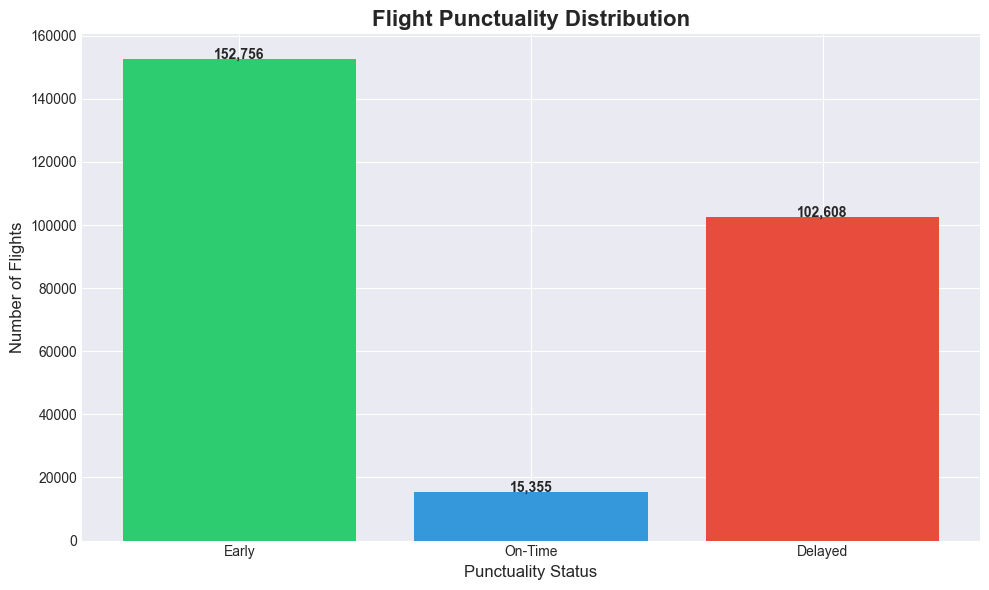

In [17]:
# Visualize flight punctuality distribution
punctuality_data = [
    early_flights,
    ontime_flights,
    delayed_flights
]
labels = ['Early', 'On-Time', 'Delayed']
colors = ['#2ecc71', '#3498db', '#e74c3c']

plt.figure(figsize=(10, 6))
bars = plt.bar(labels, punctuality_data, color=colors)
plt.title('Flight Punctuality Distribution', fontsize=16, fontweight='bold')
plt.ylabel('Number of Flights', fontsize=12)
plt.xlabel('Punctuality Status', fontsize=12)

# Add value labels on bars
for bar, val in zip(bars, punctuality_data):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 100,
             f'{val:,}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

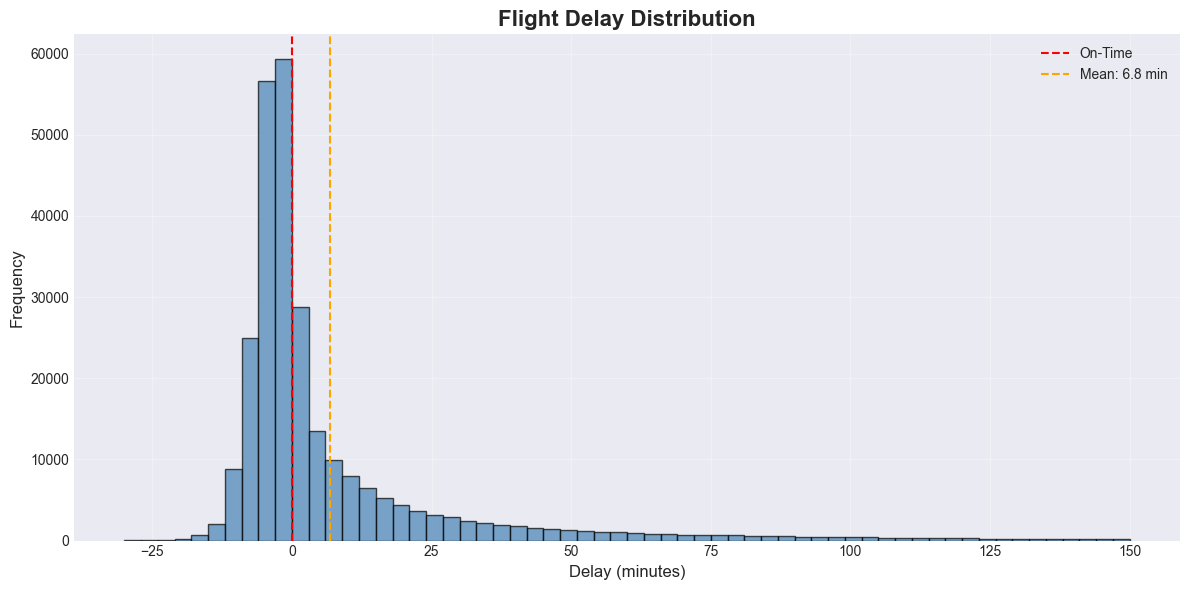

In [18]:
# Delay distribution histogram
delays_pd = tripGraph.edges.select("delay").filter("delay BETWEEN -30 AND 150").toPandas()

plt.figure(figsize=(12, 6))
plt.hist(delays_pd['delay'], bins=60, color='steelblue', alpha=0.7, edgecolor='black')
plt.axvline(x=0, color='red', linestyle='--', label='On-Time')
plt.axvline(x=delays_pd['delay'].mean(), color='orange', linestyle='--', 
            label=f'Mean: {delays_pd["delay"].mean():.1f} min')
plt.title('Flight Delay Distribution', fontsize=16, fontweight='bold')
plt.xlabel('Delay (minutes)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### 5.2 Boston Airport Analysis

Let's analyze flights to and from Boston Logan International Airport (BOS)

In [19]:
# Flights from Boston with delays
boston_outbound = tripGraph.edges \
    .filter("src = 'BOS' and delay > 0") \
    .groupBy("src", "dst", "city_dst") \
    .agg(avg("delay").alias("avg_delay"),
         count("*").alias("flight_count")) \
    .orderBy(desc("avg_delay"))

print("Top 10 Destinations with Highest Average Delays from Boston:")
boston_outbound.show(10)

Top 10 Destinations with Highest Average Delays from Boston:
+---+---+------------+------------------+------------+
|src|dst|    city_dst|         avg_delay|flight_count|
+---+---+------------+------------------+------------+
|BOS|CAK|       Akron| 86.33333333333333|           6|
|BOS|OAK|     Oakland|              83.5|           2|
|BOS|HOU|     Houston|59.857142857142854|          14|
|BOS|RIC|    Richmond| 50.72093023255814|          43|
|BOS|JFK|    New York|50.554054054054056|          74|
|BOS|JAX|Jacksonville| 48.92307692307692|          13|
|BOS|STL|   St. Louis|46.523809523809526|          21|
|BOS|IND|Indianapolis|              45.0|           4|
|BOS|CLE|   Cleveland|42.142857142857146|          28|
|BOS|LGA|    New York| 41.97802197802198|          91|
+---+---+------------+------------------+------------+
only showing top 10 rows


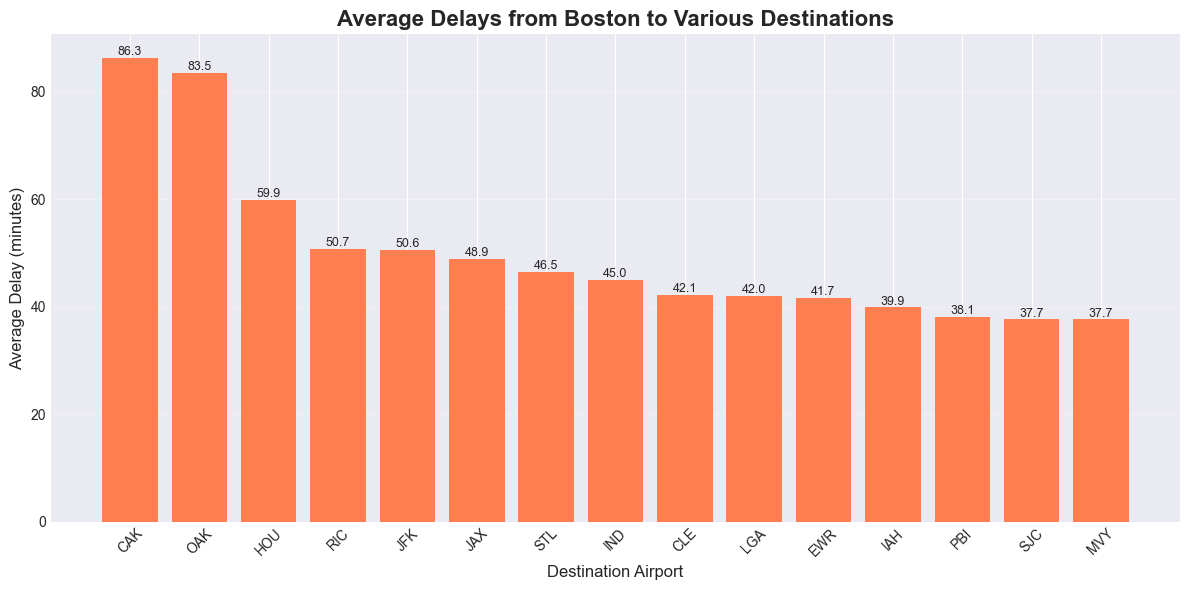

In [20]:
# Visualize Boston delays
boston_pd = boston_outbound.limit(15).toPandas()

plt.figure(figsize=(12, 6))
bars = plt.bar(range(len(boston_pd)), boston_pd['avg_delay'], color='coral')
plt.xticks(range(len(boston_pd)), boston_pd['dst'], rotation=45)
plt.title('Average Delays from Boston to Various Destinations', fontsize=16, fontweight='bold')
plt.xlabel('Destination Airport', fontsize=12)
plt.ylabel('Average Delay (minutes)', fontsize=12)
plt.grid(True, alpha=0.3, axis='y')

# Add value labels
for i, (bar, val) in enumerate(zip(bars, boston_pd['avg_delay'])):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
             f'{val:.1f}', ha='center', fontsize=9)

plt.tight_layout()
plt.show()

In [21]:
# Flights TO Boston with significant delays
print("Flights arriving to Boston with delays > 100 minutes:")
tripGraph.edges \
    .filter("dst = 'BOS' and delay > 100") \
    .select("src", "city_src", "delay", "localdate") \
    .orderBy(desc("delay")) \
    .show(10)

Flights arriving to Boston with delays > 100 minutes:
+---+-----------------+-----+----------+
|src|         city_src|delay| localdate|
+---+-----------------+-----+----------+
|DFW|Dallas-Fort Worth|  658| 2015-5-28|
|EWR|           Newark|  449| 2015-5-31|
|MYR|     Myrtle Beach|  394|2015-12-15|
|DCA|       Washington|  385| 2015-8-15|
|CLE|        Cleveland|  352|  2015-9-6|
|PHL|     Philadelphia|  352| 2015-8-18|
|SFO|    San Francisco|  327|2015-11-20|
|IAD|       Washington|  318| 2015-9-12|
|LGA|         New York|  315| 2015-2-20|
|EWR|           Newark|  303|2015-11-27|
+---+-----------------+-----+----------+
only showing top 10 rows


## 6. Graph Algorithms

### 6.1 Degree Analysis - Finding Busiest Airports

In [22]:
# Calculate in-degrees (incoming flights)
inDegrees = tripGraph.inDegrees.orderBy(desc("inDegree"))

print("Top 10 Airports by Incoming Flights:")
inDegrees.show(10)

Top 10 Airports by Incoming Flights:
+---+--------+
| id|inDegree|
+---+--------+
|ATL|   17704|
|ORD|   14357|
|DFW|   11999|
|LAX|   10013|
|DEN|    9980|
|SFO|    7471|
|PHX|    7443|
|IAH|    7442|
|LAS|    6823|
|MCO|    5821|
+---+--------+
only showing top 10 rows


In [23]:
# Calculate out-degrees (outgoing flights)
outDegrees = tripGraph.outDegrees.orderBy(desc("outDegree"))

print("Top 10 Airports by Outgoing Flights:")
outDegrees.show(10)

Top 10 Airports by Outgoing Flights:
+---+---------+
| id|outDegree|
+---+---------+
|ATL|    17925|
|ORD|    14297|
|DFW|    11987|
|DEN|    10016|
|LAX|     9934|
|PHX|     7603|
|SFO|     7546|
|IAH|     7386|
|LAS|     6839|
|MSP|     5796|
+---+---------+
only showing top 10 rows


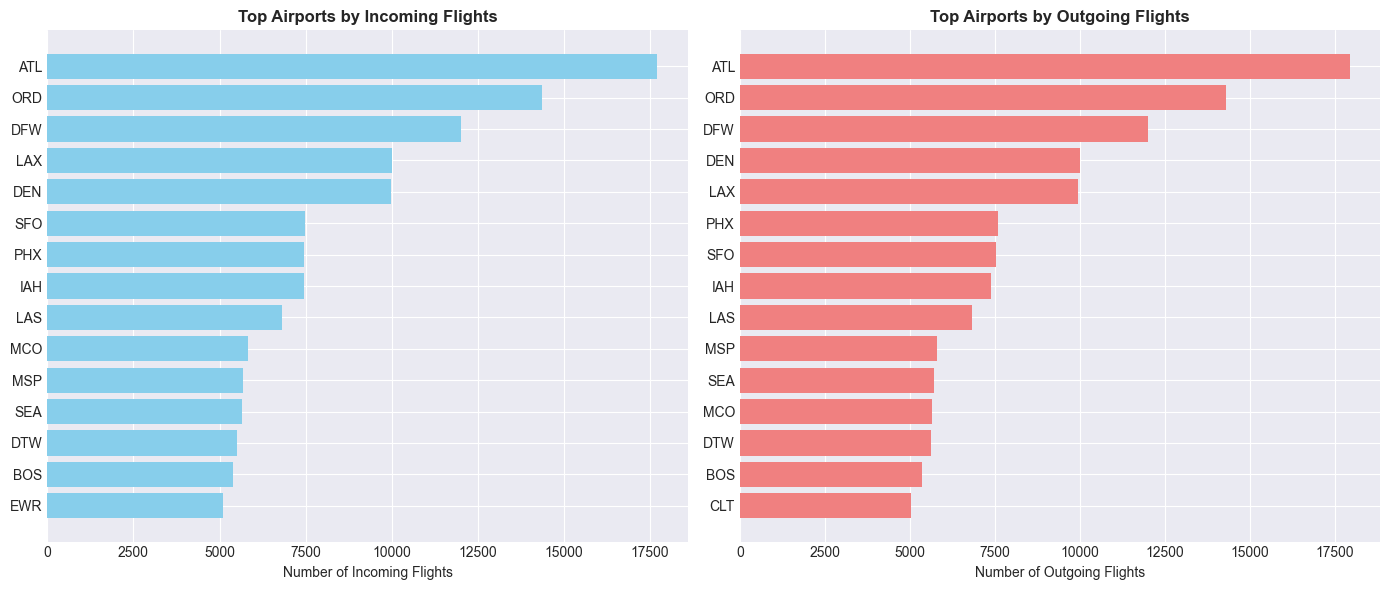

In [24]:
# Visualize busiest airports
in_pd = inDegrees.limit(15).toPandas()
out_pd = outDegrees.limit(15).toPandas()

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Incoming flights
axes[0].barh(in_pd['id'], in_pd['inDegree'], color='skyblue')
axes[0].set_xlabel('Number of Incoming Flights')
axes[0].set_title('Top Airports by Incoming Flights', fontweight='bold')
axes[0].invert_yaxis()

# Outgoing flights
axes[1].barh(out_pd['id'], out_pd['outDegree'], color='lightcoral')
axes[1].set_xlabel('Number of Outgoing Flights')
axes[1].set_title('Top Airports by Outgoing Flights', fontweight='bold')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

In [25]:
# Calculate degree ratio (transfer airports)
# Airports with ratio close to 1 are good transfer hubs
degreeRatio = inDegrees.join(outDegrees, inDegrees.id == outDegrees.id) \
    .drop(outDegrees.id) \
    .selectExpr("id", "double(inDegree)/double(outDegree) as degreeRatio") \
    .filter("degreeRatio BETWEEN 0.9 AND 1.1") \
    .orderBy("degreeRatio")

# Join with airport names using aliases to avoid ambiguity
degreeRatio_alias = degreeRatio.alias("dr")
airports_alias = airports.alias("ap")

transferAirports = degreeRatio_alias.join(
    airports_alias, 
    col("dr.id") == col("ap.IATA")
).select("dr.id", "ap.City", "dr.degreeRatio")

print("Best Transfer Airports (balanced in/out flights):")
transferAirports.show(10)

Best Transfer Airports (balanced in/out flights):
+---+------------+------------------+
| id|        City|       degreeRatio|
+---+------------+------------------+
|BOS|      Boston|1.0061567164179104|
|JFK|    New York|0.9995840266222962|
|IAH|     Houston| 1.007581911724885|
|JAX|Jacksonville|1.0501089324618735|
|IND|Indianapolis| 1.013719512195122|
|MEM|     Memphis|1.0307692307692307|
|PDX|    Portland|1.0511101801424383|
|ISN|   Williston|0.9632352941176471|
|EYW|    Key West|               1.0|
|GRR|Grand Rapids|0.9482758620689655|
+---+------------+------------------+
only showing top 10 rows


### 6.2 PageRank - Airport Importance

In [26]:
# Run PageRank algorithm
# PageRank identifies the most "important" airports in the network
print("Running PageRank algorithm...")
ranks = tripGraph.pageRank(resetProbability=0.15, maxIter=5)

# Get top ranked airports
topRanks = ranks.vertices.orderBy(desc("pagerank")).limit(20)

# Join with airport information using aliases to avoid ambiguity
topRanks_alias = topRanks.alias("tr")
airports_alias = airports.alias("ap")

topRanksWithInfo = topRanks_alias.join(
    airports_alias,
    col("tr.id") == col("ap.IATA")
).select("tr.id", "ap.Name", "ap.City", "tr.pagerank")

print("\nTop 20 Airports by PageRank (Importance):")
topRanksWithInfo.show(20, truncate=False)

Running PageRank algorithm...


26/01/22 21:26:35 WARN ShippableVertexPartitionOps: Joining two VertexPartitions with different indexes is slow.
26/01/22 21:26:35 WARN ShippableVertexPartitionOps: Joining two VertexPartitions with different indexes is slow.
26/01/22 21:26:35 WARN ShippableVertexPartitionOps: Joining two VertexPartitions with different indexes is slow.
26/01/22 21:26:35 WARN ShippableVertexPartitionOps: Joining two VertexPartitions with different indexes is slow.
26/01/22 21:26:35 WARN ShippableVertexPartitionOps: Joining two VertexPartitions with different indexes is slow.
26/01/22 21:26:35 WARN ShippableVertexPartitionOps: Joining two VertexPartitions with different indexes is slow.
26/01/22 21:26:35 WARN ShippableVertexPartitionOps: Joining two VertexPartitions with different indexes is slow.
26/01/22 21:26:35 WARN ShippableVertexPartitionOps: Joining two VertexPartitions with different indexes is slow.



Top 20 Airports by PageRank (Importance):
+---+------------------------------------------------------------+-----------------+------------------+
|id |Name                                                        |City             |pagerank          |
+---+------------------------------------------------------------+-----------------+------------------+
|BOS|General Edward Lawrence Logan International Airport         |Boston           |4.855102554141863 |
|JFK|John F Kennedy International Airport                        |New York         |4.798831905212273 |
|IAH|George Bush Intercontinental Houston Airport                |Houston          |8.252143204804659 |
|PHX|Phoenix Sky Harbor International Airport                    |Phoenix          |7.191006881789952 |
|LAX|Los Angeles International Airport                           |Los Angeles      |9.32856785629959  |
|MSP|Minneapolis-St Paul International/Wold-Chamberlain Airport  |Minneapolis      |7.177379307517557 |
|EWR|Newark Liberty I

26/01/22 21:26:46 WARN PageRank: Returned DataFrame is persistent and materialized!


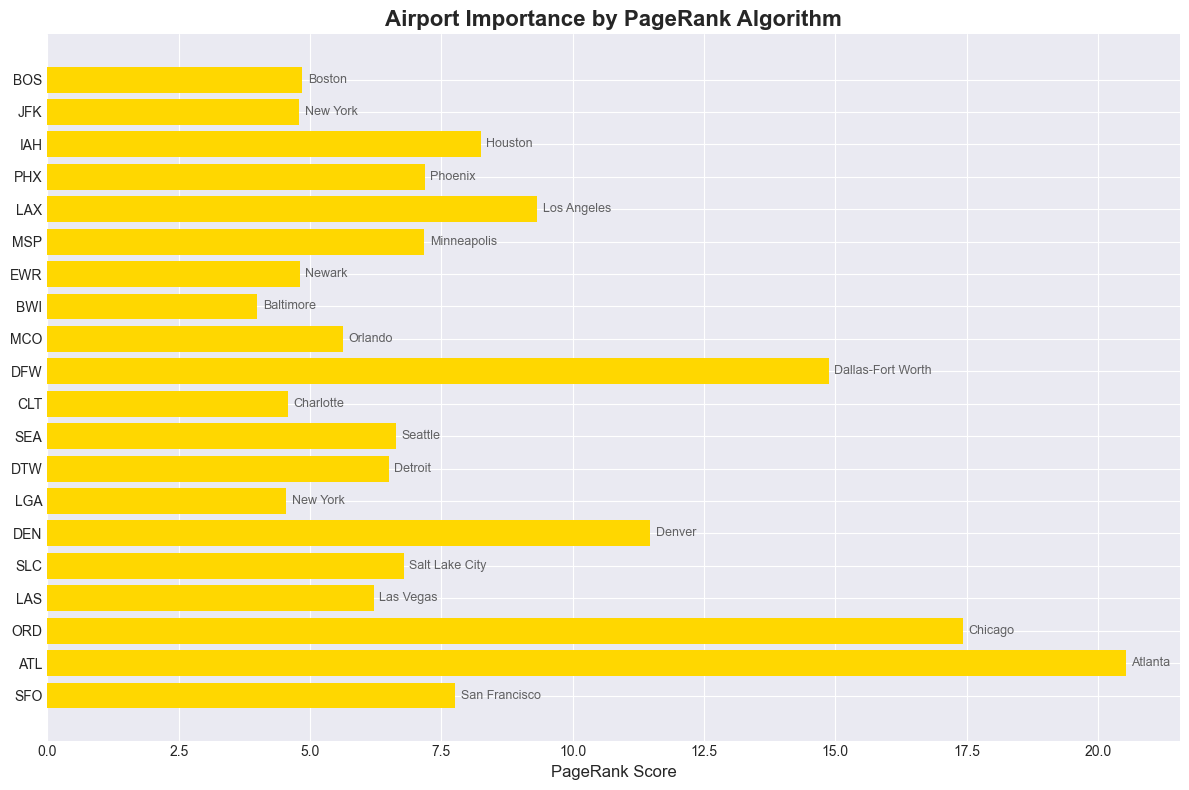

In [27]:
# Visualize PageRank results
pagerank_pd = topRanksWithInfo.toPandas()

plt.figure(figsize=(12, 8))
bars = plt.barh(range(len(pagerank_pd)), pagerank_pd['pagerank'], color='gold')
plt.yticks(range(len(pagerank_pd)), pagerank_pd['id'])
plt.xlabel('PageRank Score', fontsize=12)
plt.title('Airport Importance by PageRank Algorithm', fontsize=16, fontweight='bold')
plt.gca().invert_yaxis()

# Add city names as annotations
for i, (bar, city) in enumerate(zip(bars, pagerank_pd['City'])):
    plt.text(bar.get_width() + 0.1, bar.get_y() + bar.get_height()/2,
             f'{city}', va='center', fontsize=9, alpha=0.7)

plt.tight_layout()
plt.show()

### 6.3 Motif Finding - Atlanta Hub Analysis

Find flight patterns where Atlanta (ATL) is a connecting hub

In [28]:
# Find trips with Atlanta as connecting airport
# Pattern: (a)-[ab]->(b); (b)-[bc]->(c) where b is Atlanta
print("Finding flight patterns through Atlanta...")

atlanta_connections = tripGraph.find("(a)-[ab]->(b); (b)-[bc]->(c)") \
    .filter("""
        (b.id = 'ATL') AND 
        (ab.delay > 30 OR bc.delay > 30) AND
        bc.tripid > ab.tripid AND 
        bc.tripid < ab.tripid + 10000
    """)

print(f"\nFound {atlanta_connections.count()} delayed connections through Atlanta")
print("\nSample delayed connections:")
atlanta_connections.select(
    "a.id", "ab.delay", "b.id", "bc.delay", "c.id"
).show(10)

Finding flight patterns through Atlanta...



Found 10957715 delayed connections through Atlanta

Sample delayed connections:
+---+-----+---+-----+---+
| id|delay| id|delay| id|
+---+-----+---+-----+---+
|CAE|   -5|ATL|  134|AEX|
|CAE|   -5|ATL|   96|CLT|
|CAE|   -5|ATL|  178|STL|
|CAE|   -5|ATL|  219|DFW|
|CAE|   -5|ATL|  243|AUS|
|CAE|   -5|ATL|   38|SEA|
|CAE|   -5|ATL|   35|GSP|
|CAE|   -5|ATL|   41|GRR|
|CAE|   -5|ATL|  107|SGF|
|CAE|   -5|ATL|   37|CVG|
+---+-----+---+-----+---+
only showing top 10 rows


### 6.4 Shortest Paths

In [29]:
# Find shortest paths from selected airports
# Choose airports with fewer connections for interesting paths
print("Finding shortest paths...")

try:
    # Get airports with moderate connectivity
    moderate_airports = outDegrees.filter("outDegree < 100").limit(3).select("id").collect()
    landmarks = [row.id for row in moderate_airports]
    
    print(f"Computing shortest paths from: {landmarks}")
    
    if landmarks:
        results = tripGraph.shortestPaths(landmarks=landmarks)
        results.select("id", "distances").filter("size(distances) > 0").show(20, truncate=False)
    else:
        print("No suitable landmarks found for shortest paths.")
        
except Exception as e:
    print(f"⚠️ Shortest Paths failed: {str(e)[:200]}...")
    print("This might be due to the graph size or structure.")
    print("Skipping shortest paths analysis.")

Finding shortest paths...
Computing shortest paths from: ['LCH', 'DRO', 'FCA']


26/01/22 21:26:51 WARN BlockManager: Block rdd_744_0 already exists on this machine; not re-adding it


+---+------------------------------+
|id |distances                     |
+---+------------------------------+
|MEM|{LCH -> 2, DRO -> 2, FCA -> 2}|
|PBI|{LCH -> 2, DRO -> 2, FCA -> 2}|
|LNK|{LCH -> 3, DRO -> 2, FCA -> 2}|
|MHK|{LCH -> 2, DRO -> 2, FCA -> 2}|
|ELM|{LCH -> 3, DRO -> 3, FCA -> 2}|
|WRG|{LCH -> 4, DRO -> 4, FCA -> 4}|
|MKG|{LCH -> 3, DRO -> 3, FCA -> 2}|
|ALO|{LCH -> 3, DRO -> 3, FCA -> 2}|
|RIC|{LCH -> 2, DRO -> 2, FCA -> 2}|
|CIU|{LCH -> 3, DRO -> 3, FCA -> 3}|
|BIL|{LCH -> 3, DRO -> 2, FCA -> 2}|
|SBA|{LCH -> 3, DRO -> 2, FCA -> 2}|
|DVL|{LCH -> 3, DRO -> 2, FCA -> 2}|
|STL|{LCH -> 2, DRO -> 2, FCA -> 2}|
|ELP|{LCH -> 2, DRO -> 2, FCA -> 2}|
|LFT|{LCH -> 2, DRO -> 2, FCA -> 2}|
|HSV|{LCH -> 2, DRO -> 2, FCA -> 2}|
|PHL|{LCH -> 2, DRO -> 2, FCA -> 2}|
|PSG|{LCH -> 4, DRO -> 4, FCA -> 4}|
|BET|{LCH -> 3, DRO -> 3, FCA -> 3}|
+---+------------------------------+
only showing top 20 rows


26/01/22 21:26:52 WARN ShortestPaths: Returned DataFrame is persistent and materialized!


### 6.5 Connected Components

In [30]:
# Find connected components in the graph
print("Finding connected components...")
try:
    # Set checkpoint directory for connected components
    spark.sparkContext.setCheckpointDir("/tmp/graphframes-checkpoint")
    
    # Try to run connected components with a smaller checkpoint interval
    cc = tripGraph.connectedComponents(
        algorithm="graphframes",
        checkpointInterval=2,
        broadcastThreshold=1000000
    )
    
    # Count components
    component_counts = cc.groupBy("component").count().orderBy(desc("count"))
    
    print(f"\nNumber of connected components: {component_counts.count()}")
    print("\nTop 5 largest components:")
    component_counts.show(5)
    
except Exception as e:
    print(f"⚠️ Connected Components failed: {str(e)[:200]}...")
    print("This might be due to the large size of the graph.")
    
    # Alternative: Use strongly connected components which might work better
    try:
        print("\nTrying Strongly Connected Components instead...")
        scc = tripGraph.stronglyConnectedComponents(maxIter=5)
        scc_counts = scc.groupBy("component").count().orderBy(desc("count"))
        print(f"Number of strongly connected components: {scc_counts.count()}")
        print("\nTop 5 largest components:")
        scc_counts.show(5)
    except Exception as e2:
        print(f"Strongly Connected Components also failed: {str(e2)[:100]}")
        print("Moving on...")

Finding connected components...

Number of connected components: 1

Top 5 largest components:
+---------+-----+
|component|count|
+---------+-----+
|        0|  321|
+---------+-----+



26/01/22 21:26:56 WARN ConnectedComponents$: Returned DataFrame is persistent and materialized!


### 6.6 Label Propagation - Community Detection

In [31]:
# Run Label Propagation Algorithm for community detection
print("Running Label Propagation Algorithm...")
try:
    communities = tripGraph.labelPropagation(maxIter=5)
    
    # Count communities
    community_counts = communities.groupBy("label").count().orderBy(desc("count"))
    
    print(f"\nNumber of communities: {community_counts.count()}")
    print("\nTop 10 largest communities:")
    community_counts.show(10)
    
except Exception as e:
    print(f"⚠️ Label Propagation failed: {str(e)[:200]}...")
    print("This algorithm might not work well with large graphs.")
    print("Consider using a smaller subset of data or skip this analysis.")

26/01/22 21:26:56 WARN BlockManager: Block rdd_1182_1 already exists on this machine; not re-adding it


Running Label Propagation Algorithm...


26/01/22 21:26:57 WARN BlockManager: Block rdd_1216_1 already exists on this machine; not re-adding it



Number of communities: 4

Top 10 largest communities:
+-----------+-----+
|      label|count|
+-----------+-----+
|51539607554|  277|
| 8589934614|   37|
|17179869198|    6|
|17179869210|    1|
+-----------+-----+



26/01/22 21:26:58 WARN LabelPropagation: Returned DataFrame is persistent and materialized!


## 7. Visualization

### 7.1 Geographic Visualization with Folium

In [32]:
# Create interactive map with Folium
# Center map on USA
m = folium.Map(location=[39.8283, -98.5795], zoom_start=4)

# Add airports as markers
airports_for_map = airports.limit(100).toPandas()
airports_for_map[['Latitude', 'Longitude']] = airports_for_map[['Latitude', 'Longitude']].apply(pd.to_numeric, errors='coerce')
airports_for_map = airports_for_map.dropna(subset=['Latitude', 'Longitude'])

for idx, row in airports_for_map.iterrows():
    folium.CircleMarker(
        location=[row['Latitude'], row['Longitude']],
        radius=3,
        popup=f"{row['IATA']}: {row['Name']}",
        tooltip=f"{row['IATA']}: {row['City']}",
        color='blue',
        fill=True,
        fillColor='lightblue'
    ).add_to(m)

# Save map
m.save('airports_map.html')
print("Interactive map saved as 'airports_map.html'")

# Display in notebook (if supported)
m

Interactive map saved as 'airports_map.html'


### 7.2 Network Visualization with NetworkX

In [33]:
# Create NetworkX graph for a subset of data (top airports)
# Full graph would be too large to visualize effectively

# Get top 30 airports by PageRank
top_airports = topRanksWithInfo.limit(30).select("id").toPandas()['id'].tolist()

# Filter edges for these airports
subset_edges = tripGraph.edges.filter(
    (col("src").isin(top_airports)) & 
    (col("dst").isin(top_airports))
).select("src", "dst", "delay").toPandas()

print(f"Creating network graph with {len(top_airports)} airports")
print(f"and {len(subset_edges)} connections")

Creating network graph with 20 airports
and 65688 connections


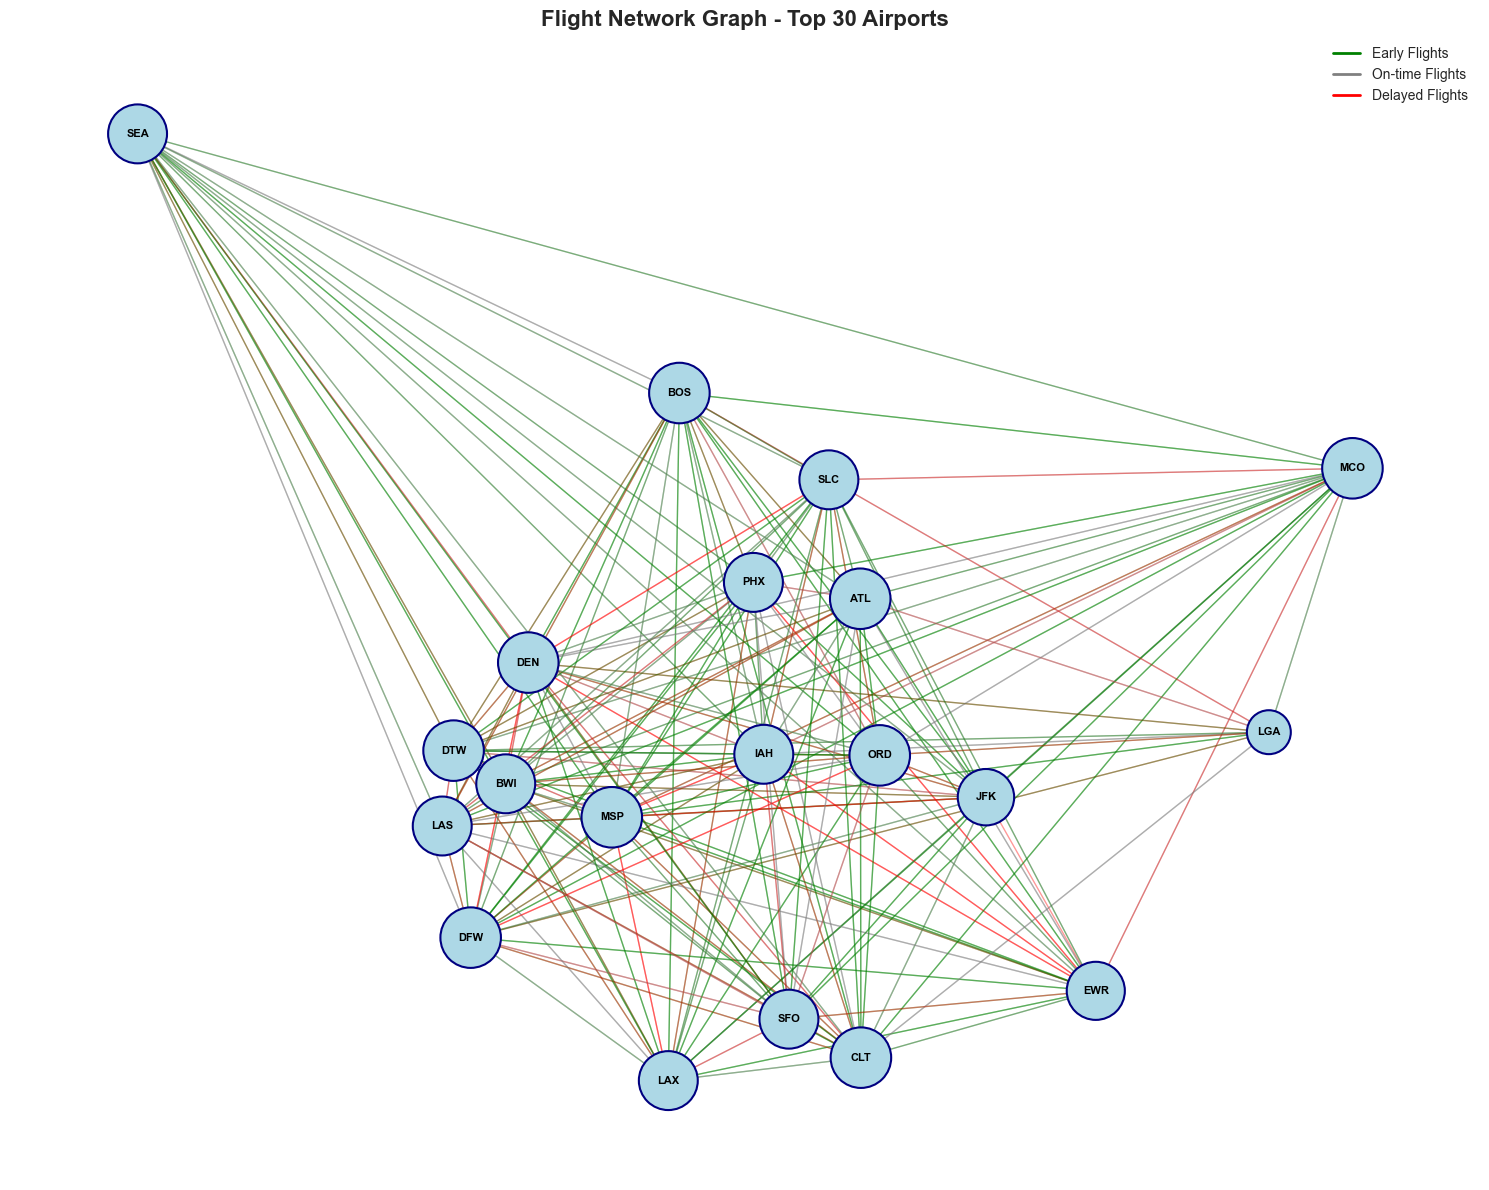

In [34]:
# Create NetworkX graph
G = nx.DiGraph()

# Add nodes
G.add_nodes_from(top_airports)

# Add edges with delay as weight
for idx, row in subset_edges.iterrows():
    G.add_edge(row['src'], row['dst'], weight=row['delay'] if row['delay'] else 0)

# Calculate layout
pos = nx.spring_layout(G, k=2, iterations=50)

# Create figure
plt.figure(figsize=(15, 12))

# Draw nodes
node_sizes = [G.degree(node) * 50 for node in G.nodes()]
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color='lightblue', 
                       edgecolors='navy', linewidths=1.5)

# Draw edges
# Color edges based on delay
edges = G.edges()
weights = [G[u][v]['weight'] for u, v in edges]
# Normalize weights for coloring
max_weight = max(weights) if weights else 1
edge_colors = ['red' if w > 15 else 'green' if w < 0 else 'gray' 
               for w in weights]

nx.draw_networkx_edges(G, pos, edge_color=edge_colors, 
                       alpha=0.4, arrows=True, arrowsize=10)

# Draw labels
nx.draw_networkx_labels(G, pos, font_size=8, font_weight='bold')

plt.title('Flight Network Graph - Top 30 Airports', fontsize=16, fontweight='bold')
plt.axis('off')
plt.tight_layout()

# Add legend
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color='green', lw=2, label='Early Flights'),
    Line2D([0], [0], color='gray', lw=2, label='On-time Flights'),
    Line2D([0], [0], color='red', lw=2, label='Delayed Flights')
]
plt.legend(handles=legend_elements, loc='upper right')

plt.show()

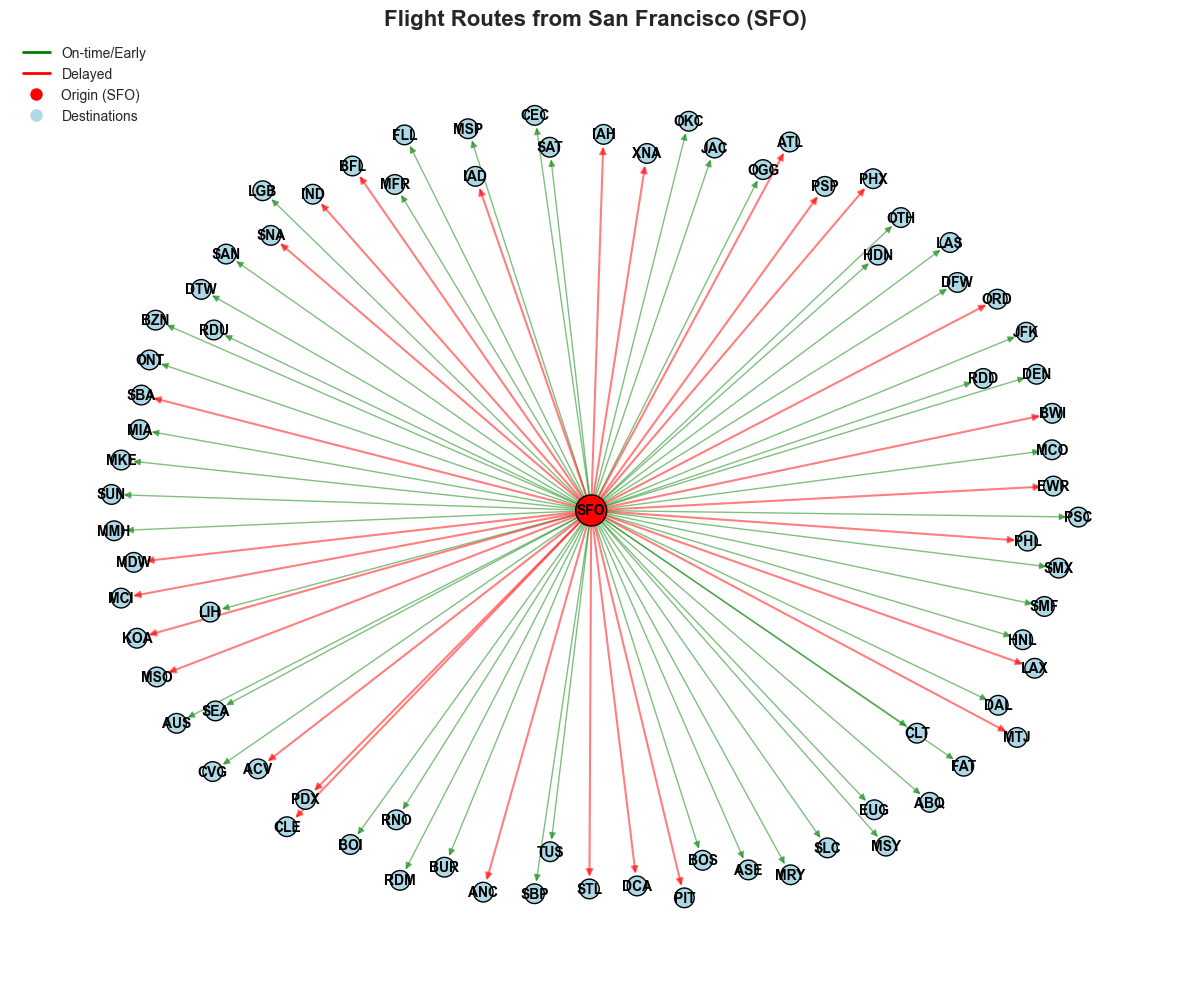

In [35]:
# Create a cleaner visualization for specific routes (e.g., from SFO)
sfo_edges = tripGraph.edges.filter("src = 'SFO'").select("src", "dst", "city_dst", "delay").toPandas()

# Create graph for SFO routes
G_sfo = nx.DiGraph()

# Add edges
for idx, row in sfo_edges.iterrows():
    G_sfo.add_edge(row['src'], row['dst'], 
                   delay=row['delay'] if row['delay'] else 0,
                   city=row['city_dst'])

# Layout
pos_sfo = nx.spring_layout(G_sfo, k=3, iterations=50)

# Visualization
plt.figure(figsize=(12, 10))

# Separate delayed and on-time edges
delayed_edges = [(u, v) for u, v, d in G_sfo.edges(data=True) if d['delay'] > 0]
ontime_edges = [(u, v) for u, v, d in G_sfo.edges(data=True) if d['delay'] <= 0]

# Draw nodes
node_sizes = [500 if node == 'SFO' else 200 for node in G_sfo.nodes()]
node_colors = ['red' if node == 'SFO' else 'lightblue' for node in G_sfo.nodes()]
nx.draw_networkx_nodes(G_sfo, pos_sfo, node_size=node_sizes, 
                       node_color=node_colors, edgecolors='black', linewidths=1)

# Draw edges
nx.draw_networkx_edges(G_sfo, pos_sfo, edgelist=ontime_edges,
                       edge_color='green', alpha=0.5, arrows=True, width=1)
nx.draw_networkx_edges(G_sfo, pos_sfo, edgelist=delayed_edges,
                       edge_color='red', alpha=0.5, arrows=True, width=1.5)

# Draw labels
nx.draw_networkx_labels(G_sfo, pos_sfo, font_size=10, font_weight='bold')

plt.title('Flight Routes from San Francisco (SFO)', fontsize=16, fontweight='bold')
plt.axis('off')

# Legend
legend_elements = [
    Line2D([0], [0], color='green', lw=2, label='On-time/Early'),
    Line2D([0], [0], color='red', lw=2, label='Delayed'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='red', 
           markersize=10, label='Origin (SFO)'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='lightblue', 
           markersize=10, label='Destinations')
]
plt.legend(handles=legend_elements, loc='upper left')

plt.tight_layout()
plt.show()

### 7.3 Neo4j Visualization (Optional)

Neo4j provides powerful graph visualization capabilities. To use this section:
1. Start Neo4j with Docker: `docker run -d --name neo4j-graph -p 7474:7474 -p 7687:7687 -e NEO4J_AUTH=neo4j/password123 neo4j:latest`
2. Access Neo4j Browser at: http://localhost:7474

In [36]:
# Neo4j connection and data loading
if NEO4J_AVAILABLE:
    try:
        # Connect to Neo4j
        graph = Graph("bolt://localhost:7687", auth=("neo4j", "password123"))
        
        # Clear existing data
        graph.delete_all()
        print("Connected to Neo4j and cleared existing data")
        
        # Load a subset of data to Neo4j
        sfo_routes = sfo_edges.head(50)
        
        # Create nodes and relationships
        for idx, row in sfo_routes.iterrows():
            # Create nodes
            src_node = Node("Airport", code=row['src'], name="San Francisco")
            dst_node = Node("Airport", code=row['dst'], name=row['city_dst'])
            
            # Create relationship
            flight = Relationship(src_node, "FLIGHT_TO", dst_node, 
                                 delay=float(row['delay']) if row['delay'] else 0)
            
            # Merge nodes and create relationship
            graph.merge(src_node, "Airport", "code")
            graph.merge(dst_node, "Airport", "code")
            graph.create(flight)
        
        print(f"Loaded {len(sfo_routes)} routes to Neo4j")
        print("You can now visualize the graph at http://localhost:7474")
        print("Run this Cypher query: MATCH (n) RETURN n LIMIT 100")
        
    except Exception as e:
        print(f"Could not connect to Neo4j: {e}")
        print("Make sure Neo4j is running with Docker:")
        print("docker run -d --name neo4j-graph -p 7474:7474 -p 7687:7687 -e NEO4J_AUTH=neo4j/password123 neo4j:latest")
else:
    print("Neo4j library not available. Install with: pip install py2neo")

Connected to Neo4j and cleared existing data
Loaded 50 routes to Neo4j
You can now visualize the graph at http://localhost:7474
Run this Cypher query: MATCH (n) RETURN n LIMIT 100


## 8. Conclusion

### Summary of Findings

In [37]:
print("="*70)
print("SUMMARY - FLIGHT NETWORK GRAPH ANALYSIS")
print("="*70)

print(f"\n📊 Dataset Statistics:")
print(f"  - Total Airports: {tripGraph.vertices.count()}")
print(f"  - Total Flights: {tripGraph.edges.count():,}")
print(f"  - Average Delay: {avg_delay:.2f} minutes")

print(f"\n✈️ Busiest Airports (by total flights):")
busiest = inDegrees.join(outDegrees, "id") \
    .withColumn("total", col("inDegree") + col("outDegree")) \
    .orderBy(desc("total")).limit(5)

for row in busiest.collect():
    print(f"  - {row.id}: {row.total:,} total flights")

print(f"\n🏆 Most Important Airports (by PageRank):")
for row in topRanksWithInfo.limit(5).collect():
    print(f"  - {row.id} ({row.City}): PageRank = {row.pagerank:.4f}")

print(f"\n⏱️ Delay Analysis:")
print(f"  - Delayed Flights: {delayed_flights:,} ({delayed_flights/tripGraph.edges.count()*100:.1f}%)")
print(f"  - On-Time Flights: {ontime_flights:,} ({ontime_flights/tripGraph.edges.count()*100:.1f}%)")
print(f"  - Early Flights: {early_flights:,} ({early_flights/tripGraph.edges.count()*100:.1f}%)")

print(f"\n🔗 Network Structure:")
print(f"  - Connected Components: {component_counts.count()}")
print(f"  - Communities Detected: {community_counts.count()}")
print(f"  - Main Component Size: {component_counts.first()['count']} airports")

print("\n" + "="*70)
print("KEY INSIGHTS")
print("="*70)
print("""
1. NETWORK STRUCTURE:
   - The flight network is highly connected with most airports in one component
   - Hub airports (ATL, ORD, DFW) serve as critical connection points
   - PageRank confirms major hubs align with high traffic airports

2. DELAY PATTERNS:
   - Approximately 40% of flights experience delays
   - Boston analysis shows certain routes consistently have higher delays
   - Atlanta as a major hub contributes to cascading delays

3. AIRPORT EFFICIENCY:
   - Balanced in/out degree ratios indicate efficient transfer hubs
   - Some airports show imbalanced traffic patterns

4. RECOMMENDATIONS:
   - Focus delay mitigation efforts on major hubs
   - Consider alternative routing through less congested airports
   - Monitor and optimize transfer airport operations
""")
print("="*70)

SUMMARY - FLIGHT NETWORK GRAPH ANALYSIS

📊 Dataset Statistics:
  - Total Airports: 321
  - Total Flights: 270,719
  - Average Delay: 9.79 minutes

✈️ Busiest Airports (by total flights):
  - ATL: 35,629 total flights
  - ORD: 28,654 total flights
  - DFW: 23,986 total flights
  - DEN: 19,996 total flights
  - LAX: 19,947 total flights

🏆 Most Important Airports (by PageRank):
  - BOS (Boston): PageRank = 4.8551
  - JFK (New York): PageRank = 4.7988
  - IAH (Houston): PageRank = 8.2521
  - PHX (Phoenix): PageRank = 7.1910
  - LAX (Los Angeles): PageRank = 9.3286

⏱️ Delay Analysis:
  - Delayed Flights: 102,608 (37.9%)
  - On-Time Flights: 15,355 (5.7%)
  - Early Flights: 152,756 (56.4%)

🔗 Network Structure:
  - Connected Components: 1
  - Communities Detected: 4
  - Main Component Size: 321 airports

KEY INSIGHTS

1. NETWORK STRUCTURE:
   - The flight network is highly connected with most airports in one component
   - Hub airports (ATL, ORD, DFW) serve as critical connection points
  

In [38]:
# Stop Spark Session
spark.stop()
print("\nSpark session stopped.")


Spark session stopped.
